### Import

In [279]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import *
from vvm_var_func import *

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn.colors.xkcd_rgb as c
import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Generate sounding profile

In [13]:
def generate_prof(column_list:list):
    fname = './Data/hw3_profile.csv'
    # Read sounding data
    df    = pd.read_csv(fname, usecols=column_list)
    # Adjust temperature
    df[column_list[1]] = df[column_list[1]]+273.15
    # Add calm wind sounding
    df.insert(3, 'U', np.zeros(test['P'].shape[0]))
    df.insert(4, 'V', np.zeros(test['P'].shape[0]))
    return df

In [14]:
prof_noQC = generate_prof(['P', 'T', 'q'])

In [16]:
prof_noQC

,P,T,q,U,V
0,1005.684218,294.990000,15.735885,0.0,0.0
1,1005.000000,294.992995,15.749455,0.0,0.0
2,1004.000000,295.010000,15.781359,0.0,0.0
3,1003.000000,295.020000,15.806649,0.0,0.0
4,1002.000000,295.029200,15.831234,0.0,0.0
...,...,...,...,...,...
620,386.000000,259.304430,0.045497,0.0,0.0
621,385.000000,259.194911,0.045860,0.0,0.0
622,384.000000,259.085392,0.046222,0.0,0.0
623,383.000000,258.975874,0.046585,0.0,0.0


In [17]:
header= ' '*4+'P[hPa]'+' '*7+'T[K]'+' '*3+'Qv[g/kg]'+' '*5+'U[m/s]'+' '*5+'V[m/s]'
np.savetxt(f'./Data/hw3_noqc.txt', 
           prof_noQC, 
           header=header, comments='',
           fmt=['%10.4f', '%10.4f', '%10.4f', '%10.1f', '%10.1f'])

In [18]:
prof_QC = generate_prof(['P', 'T_new', 'q_new'])

In [19]:
prof_QC

,P,T_new,q_new,U,V
0,1005.684218,295.354361,15.138624,0.0,0.0
1,1005.000000,295.153782,15.153372,0.0,0.0
2,1004.000000,295.199270,15.182921,0.0,0.0
3,1003.000000,295.151934,15.210135,0.0,0.0
4,1002.000000,295.220055,15.230091,0.0,0.0
...,...,...,...,...,...
620,386.000000,256.190634,0.000000,0.0,0.0
621,385.000000,256.075416,0.000000,0.0,0.0
622,384.000000,255.960197,0.000000,0.0,0.0
623,383.000000,255.844979,0.000000,0.0,0.0


In [20]:
header= ' '*4+'P[hPa]'+' '*7+'T[K]'+' '*3+'Qv[g/kg]'+' '*5+'U[m/s]'+' '*5+'V[m/s]'
np.savetxt(f'./Data/hw3_qc.txt', 
           prof_QC, 
           header=header, comments='',
           fmt=['%10.4f', '%10.4f', '%10.4f', '%10.1f', '%10.1f'])

In [126]:
def Plot_prof_init(savefig=False):
    fig, ax = plt.subplots(1, 2, figsize=(6, 6), sharey=True)
    ax[0].grid(':', linewidth=0.5)
    ax[1].grid(':', linewidth=0.5)
    ax[0].plot(prof_QC['T_new']-prof_noQC['T'], prof_QC['P'], color='k', linewidth=3)
    ax[1].plot(prof_QC['q_new']-prof_noQC['q'], prof_QC['P'], color='k', linewidth=3)
    ax[0].set_ylim(1000, 800)
    ax[0].set_yticks(np.arange(1000, 800.1, -25).astype(int))
    ax[0].set_yticklabels(np.arange(1000, 800.1, -25).astype(int), fontsize=12)
    ax[0].set_xlim(-2, 0.5)
    ax[0].set_xticks(np.arange(-2, 0.51, 0.5))
    ax[0].set_xticklabels(np.arange(-2, 0.51, 0.5), fontsize=12)
    ax[0].set_title(r'$\Delta$ T (K)', fontsize=16)
    ax[1].set_xlim(-1, 0)
    ax[1].set_xticks(np.arange(-1, 0.1, 0.25))
    ax[1].set_xticklabels(np.arange(-1, 0.1, 0.25), fontsize=12)
    ax[1].set_title(r'$\Delta$ qv (g/kg)', fontsize=16)
    fig.suptitle(x=0.5, y=0.98, t='Initial Profile Diff. (QC-no QC)', fontsize=18, fontweight='bold')
    if savefig:
        plt.savefig('/data/mlcloud/ch995334/hw/Figure/hw3/init_TQprofile_diff.png', facecolor='w', bbox_inches='tight', dpi=400)
    else:
        plt.show()

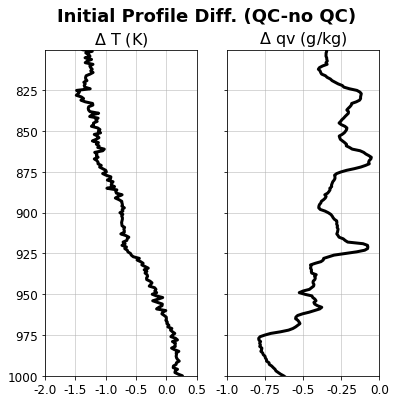

In [127]:
Plot_prof_init(savefig=True)

### Case assigning

In [27]:
case_name_no_qc = 'pbl_mod_evergreen'
case_name_qc    = 'pbl_mod_evergreen_qc'

### Load multi-timestep varfiles

In [29]:
# Get varname
var_fname, var_longname = create_var_dict(case_name_no_qc)

In [35]:
var_longname

{'vertical height of model layers, MSL': 'zc',
 'y-coordinate of grid cell centers in Cartesian system': 'yc',
 'x-coordinate of grid cell centers in Cartesian system': 'xc',
 'potential temperature': 'th',
 'water vapor mixing ratio': 'qv',
 'cloud water mixing ratio': 'qc',
 'rain mixing ratio': 'qr',
 'cloud ice mixing ratio': 'qi',
 'cloud water number mixing ratio': 'nc',
 'rain number mixing ratio': 'nr',
 'cloud ice number mixing ratio': 'ni',
 'riming cloud ice mixing ratio': 'qrim',
 'riming cloud ice volume mixing ratio': 'brim',
 'x-component of vorticity': 'xi',
 'y-component of vorticity': 'eta',
 'z-component of vorticity': 'zeta',
 'zonal velocity': 'u',
 'meridional velocity': 'v',
 'vertical velocity': 'w',
 'vertical height of model interfaces, MSL': 'zb',
 'Upward flux of shortwave radiation': 'fusw',
 'Downward flux of shortwave radiation': 'fdsw',
 'Upward flux of longwave radiation': 'fulw',
 'Downward flux of longwave radiation': 'fdlw',
 'Net shortwave heating r

#### Case: No QC

In [37]:
ds_sfc_noqc = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name_no_qc}/archive/{case_name_no_qc}.C.Surface*')

In [38]:
ds_rad_noqc = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name_no_qc}/archive/{case_name_no_qc}.L.Radiation*')

In [39]:
ds_dyn_noqc = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name_no_qc}/archive/{case_name_no_qc}.L.Dynamic*')

In [40]:
ds_thm_noqc = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name_no_qc}/archive/{case_name_no_qc}.L.Thermodynamic*')

#### Case: with QC

In [41]:
ds_sfc_qc = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name_qc}/archive/{case_name_qc}.C.Surface*')

In [42]:
ds_rad_qc = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name_qc}/archive/{case_name_qc}.L.Radiation*')

In [43]:
ds_dyn_qc = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name_qc}/archive/{case_name_qc}.L.Dynamic*')

In [44]:
ds_thm_qc = xr.open_mfdataset(f'/data/mlcloud/ch995334/VVM/DATA/{case_name_qc}/archive/{case_name_qc}.L.Thermodynamic*')

### Energy Time Series (HW1)

In [45]:
# Surface flux of potential temp.
th_flux_noqc = ds_sfc_noqc.wth
th_flux_qc   = ds_sfc_qc.wth

In [46]:
# Surface flux of potential water vapor
qv_flux_noqc = ds_sfc_noqc.wqv
qv_flux_qc   = ds_sfc_qc.wqv

In [47]:
# Downward SW @ TOA
dsw_noqc = ds_rad_noqc.fdswtoa
dsw_qc   = ds_rad_qc.fdswtoa

In [59]:
def Plot_energy_series(plot_qc=True, plot_noqc=False, savefig=False):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(':', linewidth=0.5)
    if plot_qc:
        lsw_qc     = ax.plot(np.arange(dsw_qc.shape[0]), dsw_qc[:, 0, 0], 'k', linewidth=3, label='SW @ TOA')
        lth_qc     = ax.plot(np.arange(th_flux_qc.shape[0]), th_flux_qc[:, 0, 0]*1004, c['reddish'], linewidth=3, label=r'$\theta$ flux')
        lqv_qc     = ax.plot(np.arange(qv_flux_qc.shape[0]), qv_flux_qc[:, 0, 0], c['bluish'], linewidth=3, label=r'qv flux')
    if plot_noqc:
        lsw_qc     = ax.plot(np.arange(dsw_noqc.shape[0]), dsw_noqc[:, 0, 0], 'k', linewidth=3, linestyle='--')
        lth_qc     = ax.plot(np.arange(th_flux_noqc.shape[0]), th_flux_noqc[:, 0, 0]*1004, c['reddish'], linewidth=3, linestyle='--')
        lqv_qc     = ax.plot(np.arange(qv_flux_noqc.shape[0]), qv_flux_noqc[:, 0, 0], c['bluish'], linewidth=3, linestyle='--')
        
    ax.set_xlim(0, th_flux_qc.time.shape[0])
    ax.set_xlabel('LST', fontsize=16)
    ax.set_xticks((np.array([6, 12, 18])-5)*30)
    ax.set_xticklabels([f'{i}:00' for i in range(6, 19, 6)], fontsize=14)
    ax.set_ylim(-15, 800)
    ax.set_ylabel('(W/$m^{2}$)', fontsize=16)
    ax.set_yticks(np.arange(0, 800.1, 100))
    ax.set_yticklabels(np.arange(0, 800.1, 100).astype(int), fontsize=14)
    ax.set_title(f'Evergreen\nQC[-], noQC[--]', loc='left', fontsize=16)
    ax.set_title('(1, 1)', loc='right', fontsize=16)
    ax.legend(fontsize=16)
    if savefig:
        plt.savefig('/data/mlcloud/ch995334/hw/Figure/hw3/tseries_replot.png', facecolor='w', bbox_inches='tight', dpi=400)
    else:
        plt.show()

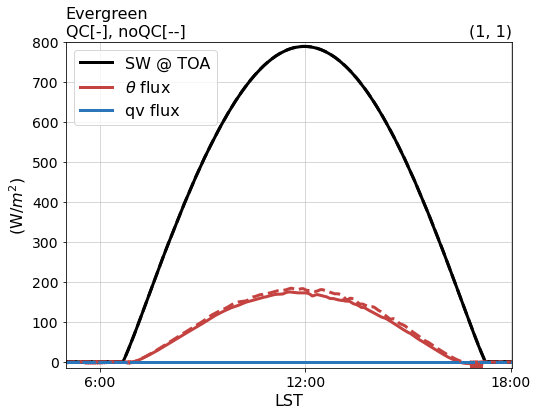

In [64]:
Plot_energy_series(plot_qc=True, plot_noqc=True, savefig=True)

### Var profiles (HW1)

In [68]:
# Motion
u_qc = ds_dyn_qc.u
v_qc = ds_dyn_qc.v
w_qc = ds_dyn_qc.w

In [67]:
u_noqc = ds_dyn_noqc.u
v_noqc = ds_dyn_noqc.v
w_noqc = ds_dyn_noqc.w

In [70]:
# Potential temperature and water vapor
th_qc  = ds_thm_qc.th
qv_qc  = ds_thm_qc.qv

In [71]:
th_noqc  = ds_thm_noqc.th
qv_noqc  = ds_thm_noqc.qv

In [124]:
def Plot_var_profiles(savefig=False):
    fig, ax = plt.subplots(1, 4, figsize=(10, 6), sharey=True, gridspec_kw={'wspace':0.25})
    # Common settings
    ax[0].grid(':', linewidth=0.5)                 # Grid lines for all subplots
    ax[1].grid(':', linewidth=0.5)
    ax[2].grid(':', linewidth=0.5)
    ax[3].grid(':', linewidth=0.5)
    tstamp = np.insert((np.array([6, 12, 18])-5)*30, 0, 0)   # Required time stamp (LST)
    llabel = ['Init.', '0600', '1200', '1800']     # Line label
    lcolor = ['black', 'bluish', 'sage', 'gold']   # Line color
    # Plot
    for tt in range(tstamp.shape[0]):
        # U plot
        ax[0].plot(u_qc.isel(time=tstamp[tt], lat=0, lon=0)-u_noqc.isel(time=tstamp[tt], lat=0, lon=0), 
                   ds_dyn_qc.lev, linewidth=3, color=c[lcolor[tt]])
        # V plot
        ax[1].plot(v_qc.isel(time=tstamp[tt], lat=0, lon=0)-v_noqc.isel(time=tstamp[tt], lat=0, lon=0), 
                   ds_dyn_qc.lev, linewidth=3, color=c[lcolor[tt]])
        # Theta plot
        ax[2].plot(th_qc.isel(time=tstamp[tt], lat=0, lon=0)-th_noqc.isel(time=tstamp[tt], lat=0, lon=0), 
                   ds_dyn_qc.lev, linewidth=3, color=c[lcolor[tt]])
        # qv plot
        ax[3].plot(1e3*(qv_qc.isel(time=tstamp[tt], lat=0, lon=0)-qv_noqc.isel(time=tstamp[tt], lat=0, lon=0)), 
                   ds_dyn_qc.lev, linewidth=3, color=c[lcolor[tt]], label=llabel[tt])
    # Info. settings
    ax[3].legend(fontsize=12)
    ax[0].set_title(r'$\Delta$U (m/s)', fontsize=16)
    ax[0].set_ylim(0, 2)
    ax[0].set_yticks(np.arange(0, 2.1, 0.25))
    ax[0].set_yticklabels(np.arange(0, 2.1, 0.25), fontsize=12)
    ax[0].set_ylabel('Height (km)', fontsize=14)
    ax[0].set_xlim(-0.8, 0.8)
    ax[0].set_xticks(np.arange(-0.5, 0.51, 0.5))
    ax[0].set_xticklabels(np.arange(-0.5, 0.51, 0.5), fontsize=12)
    ax[1].set_title(r'$\Delta$V (m/s)', fontsize=16)
    ax[1].set_xlim(-0.3, 1)
    ax[1].set_xticks([-0.3, 0.0, 0.5, 1])
    ax[1].set_xticklabels([-0.3, 0.0, 0.5, 1], fontsize=12)
    ax[2].set_title(r'$\Delta\theta$ (K)', fontsize=16)
    ax[2].set_xlim(0, 8)
    ax[2].set_xticks(np.array([0, 2.5, 5]))
    ax[2].set_xticklabels(np.array([0, 2.5, 5]), fontsize=12)
    ax[3].set_title(r'$\Delta$qv (g/kg)', fontsize=16)
    ax[3].set_xlim(-1.2, 0)
    ax[3].set_xticks(np.arange(-1, 0.1, 0.5))
    ax[3].set_xticklabels(np.arange(-1, 0.1, 0.5), fontsize=12)
    fig.suptitle(x=0.5, y=0.98, t='Difference (QC-no QC)', fontsize=18, fontweight='bold')
    if savefig:
        plt.savefig('/data/mlcloud/ch995334/hw/Figure/hw3/4profile_diff.png', facecolor='w', bbox_inches='tight', dpi=400)
    else:
        plt.show()

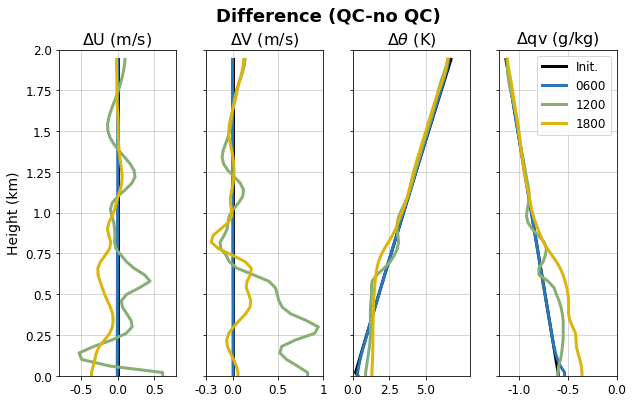

In [125]:
Plot_var_profiles(savefig=True)

### PBL Boundary

#### Domain-averaged TKE

In [129]:
tke_qc   = (u_qc**2+v_qc**2+w_qc**2).mean(dim=['lat', 'lon'])
tke_noqc = (u_noqc**2+v_noqc**2+w_noqc**2).mean(dim=['lat', 'lon'])

In [131]:
arr_tke_qc   = tke_qc.values
arr_tke_noqc = tke_noqc.values

#### Domain-averaged Enstrophy

In [133]:
xi_qc, eta_qc, zeta_qc = ds_dyn_qc.xi, ds_dyn_qc.eta, ds_dyn_qc.zeta
xi_noqc, eta_noqc, zeta_noqc = ds_dyn_noqc.xi, ds_dyn_noqc.eta, ds_dyn_noqc.zeta

In [134]:
enst_qc   = (xi_qc**2+eta_qc**2+zeta_qc**2).mean(dim=['lat', 'lon'])
enst_noqc = (xi_noqc**2+eta_noqc**2+zeta_noqc**2).mean(dim=['lat', 'lon'])

In [135]:
arr_enst_qc   = enst_qc.values
arr_enst_noqc = enst_noqc.values

#### Height where theta=theta(lev=0)+0.5K

In [136]:
def find_level(pt, levels):
    # Iterate over levels and find the first level where pt >= pt[lev0] + 0.5
    target_temp = pt[0] + 0.5
    idx = np.argmax(pt >= target_temp, axis=0)
    
    # Set to 0 if no level satisfies the condition
    idx = np.where(np.any(pt >= target_temp, axis=0), idx, 0)
    return levels[idx]

In [139]:
th05_qc = xr.apply_ufunc(
    find_level,
    th_qc,
    th_qc.lev,
    input_core_dims=[['lev'], ['lev']],
    vectorize=True,  # Apply across all other dimensions
    dask="parallelized",  # Use Dask for larger datasets
    output_dtypes=[float]  # Output will be float
).mean(dim=['lat', 'lon'])

In [140]:
th05_noqc = xr.apply_ufunc(
    find_level,
    th_noqc,
    th_noqc.lev,
    input_core_dims=[['lev'], ['lev']],
    vectorize=True,  # Apply across all other dimensions
    dask="parallelized",  # Use Dask for larger datasets
    output_dtypes=[float]  # Output will be float
).mean(dim=['lat', 'lon'])

In [141]:
arr_th05_qc   = th05_qc.values
arr_th05_noqc = th05_noqc.values

#### d_theta/dz max

In [142]:
arr_th_qc   = th_qc.values
arr_th_noqc = th_noqc.values

In [143]:
arr_th_slope_qc   = (arr_th_qc[:, 1:, ...]-arr_th_qc[:, :-1, ...])/0.02
arr_th_slope_noqc = (arr_th_noqc[:, 1:, ...]-arr_th_noqc[:, :-1, ...])/0.02

In [144]:
arr_slope_idx_qc   = np.argmax(arr_th_slope_qc, axis=1)
arr_slope_idx_noqc = np.argmax(arr_th_slope_noqc, axis=1)

In [148]:
slope_idx_qc   = xr.DataArray(arr_slope_idx_qc, dims=['time', 'lat', 'lon'])
slope_idx_noqc = xr.DataArray(arr_slope_idx_noqc, dims=['time', 'lat', 'lon'])

In [149]:
dthdz_H_qc   = th_qc.lev.isel(lev=slope_idx_qc).mean(dim=['lat', 'lon'])
dthdz_H_noqc = th_noqc.lev.isel(lev=slope_idx_noqc).mean(dim=['lat', 'lon'])

In [150]:
arr_dthdz_H_qc   = dthdz_H_qc.values
arr_dthdz_H_noqc = dthdz_H_noqc.values

#### Plot

In [222]:
def Plot_pbl_diff_tke(savefig=False):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.grid(':', linewidth=0.5)
    # TKE
    bounds = np.array([-0.8, -0.6, -0.4, -0.2, -0.05, 0, 0.05, 0.2])
    cmap_  = cmaps.cmocean_balance[np.array([10, 20, 50, 80 ,100, 128, 128, 160, 200])]
    norm   = colors.BoundaryNorm(bounds, cmap_.N, extend='both')
    im = ax.contourf(tke_qc.time, tke_qc.lev, arr_tke_qc.T-arr_tke_noqc.T, 
                     levels=bounds, 
                     cmap=cmap_, 
                     extend='both', norm=norm)
    # Theta+0.5
    ax.plot(tke_qc.time, arr_th05_qc, color='grey', linewidth=3, alpha=0.75, label=r'$\theta$(lev=0)+0.5K')
    ax.plot(tke_noqc.time, arr_th05_noqc, color='grey', linewidth=3, alpha=0.75, linestyle='--')
    # max. theta variability
    ax.plot(tke_qc.time, arr_dthdz_H_qc, color='k', linewidth=3, alpha=0.75, label=r'd$\theta$/dz max.')
    ax.plot(tke_noqc.time, arr_dthdz_H_noqc, color='k', linewidth=3, alpha=0.75, linestyle='--')
    
    # Info settings
    ax.set_xticks(tke_qc.time[::90])
    ax.set_xticklabels([f'{tke_qc.time.dt.hour[i]+5:02d}:{tke_qc.time.dt.minute[i]:02d}' for i in range(0, tke_qc.shape[0], 90)], 
                       fontsize=13)
    ax.set_xlabel('Local time', fontsize=14)
    ax.set_yticks(np.arange(0, 1.9, 0.25))
    ax.set_yticklabels(np.arange(0, 1.9, 0.25), fontsize=13)
    ax.set_ylabel('Height (km)', fontsize=14)
    ax.legend(fontsize=12, loc='upper right')
    ax.set_title('PBL Height', fontsize=16)
    ax.set_title('Domain-averaged', loc='right', fontsize=12)
    ax.set_title('Shading: QC - no QC\nLine: QC[-], no QC[--]', loc='left', fontsize=12)
    
    cbar = fig.colorbar(im, extend='both')
    cbar.set_ticks(ticks=bounds, labels=bounds)
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('TKE Diff. ($m^{2}/s^{2}$)', fontsize=14)
    if savefig:
        plt.savefig('/data/mlcloud/ch995334/hw/Figure/hw3/pbl_height_diff_tke.png', facecolor='w', bbox_inches='tight', dpi=400)
    else:
        plt.show()
    

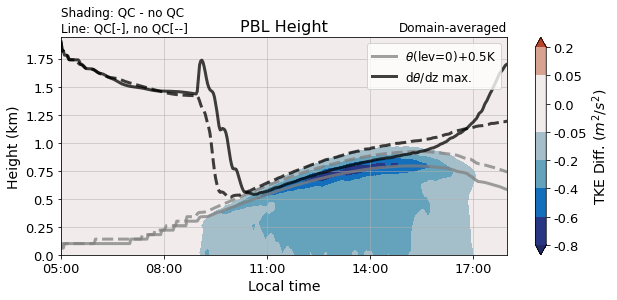

In [277]:
Plot_pbl_diff_tke(savefig=True)

In [275]:
def Plot_pbl_diff_enstrophy(savefig=False):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.grid(':', linewidth=0.5)
    # Enstrophy
    bounds = np.array([-1.5, -1.2, -0.9, -0.6, -0.3, -0.05, 0, 0.05, 0.3, 0.6])
    cmap_  = cmaps.cmocean_balance[np.array([10, 20, 50, 70, 90 ,100, 128, 128, 160, 200, 220])]
    norm   = colors.BoundaryNorm(bounds, cmap_.N, extend='both')
    im = ax.contourf(enst_qc.time, enst_qc.lev, (arr_enst_qc.T-arr_enst_noqc.T)*1e4, 
                     levels=bounds, 
                     cmap=cmap_, 
                     extend='both', norm=norm)
    # Theta+0.5
    ax.plot(tke_qc.time, arr_th05_qc, color='grey', linewidth=3, alpha=0.75, label=r'$\theta$(lev=0)+0.5K')
    ax.plot(tke_noqc.time, arr_th05_noqc, color='grey', linewidth=3, alpha=0.75, linestyle='--')
    # max. theta variability
    ax.plot(tke_qc.time, arr_dthdz_H_qc, color='k', linewidth=3, alpha=0.75, label=r'd$\theta$/dz max.')
    ax.plot(tke_noqc.time, arr_dthdz_H_noqc, color='k', linewidth=3, alpha=0.75, linestyle='--')
    
    # Info settings
    ax.set_xticks(tke_qc.time[::90])
    ax.set_xticklabels([f'{tke_qc.time.dt.hour[i]+5:02d}:{tke_qc.time.dt.minute[i]:02d}' for i in range(0, tke_qc.shape[0], 90)], 
                       fontsize=13)
    ax.set_xlabel('Local time', fontsize=14)
    ax.set_yticks(np.arange(0, 1.9, 0.25))
    ax.set_yticklabels(np.arange(0, 1.9, 0.25), fontsize=13)
    ax.set_ylabel('Height (km)', fontsize=14)
    ax.legend(fontsize=12, loc='upper right')
    ax.set_title('PBL Height', fontsize=16)
    ax.set_title('Domain-averaged', loc='right', fontsize=12)
    ax.set_title('Shading: QC - no QC\nLine: QC[-], no QC[--]', loc='left', fontsize=12)
    
    cbar = fig.colorbar(im, extend='both')
    cbar.set_ticks(ticks=bounds, labels=[f'{i:4.2f}' for i in bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('Enstrophy Diff. (1$0^{-4}$$s^{-2}$)', fontsize=14)
    if savefig:
        plt.savefig('/data/mlcloud/ch995334/hw/Figure/hw3/pbl_height_diff_enstrophy.png', facecolor='w', bbox_inches='tight', dpi=400)
    else:
        plt.show()

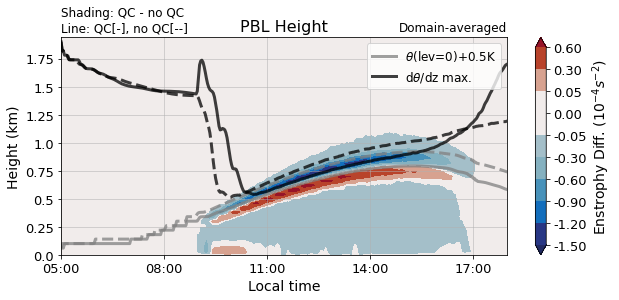

In [276]:
Plot_pbl_diff_enstrophy(savefig=True)

In [273]:
def Plot_pbl_diff_theta(savefig=False):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.grid(':', linewidth=0.5)
    # theta
    """bounds = np.array([-1.5, -1.2, -0.9, -0.6, -0.3, -0.05, 0, 0.05, 0.3, 0.6])
    cmap_  = cmaps.cmocean_balance[np.array([10, 20, 50, 70, 90 ,100, 128, 128, 160, 200, 220])]
    norm   = colors.BoundaryNorm(bounds, cmap_.N, extend='both')
    im = ax.contourf(enst_qc.time, enst_qc.lev, (arr_enst_qc.T-arr_enst_noqc.T)*1e4, 
                     levels=bounds, 
                     cmap=cmap_, 
                     extend='both', norm=norm)"""
    im = ax.contourf(th_qc.time, th_qc.lev, np.mean(arr_th_qc, axis=(2, 3)).T-np.mean(arr_th_noqc, axis=(2, 3)).T,
                     levels=np.arange(1, 6.1, 0.5), cmap=cmaps.cmocean_matter_r, 
                     extend='both')
    cs = ax.contour(th_qc.time, th_qc.lev, np.mean(arr_th_qc, axis=(2, 3)).T-np.mean(arr_th_noqc, axis=(2, 3)).T,
                     levels=np.arange(1, 6.1, 0.5), colors='w')
    # Theta+0.5
    ax.plot(tke_qc.time, arr_th05_qc, color='grey', linewidth=3, alpha=0.75, label=r'$\theta$(lev=0)+0.5K')
    ax.plot(tke_noqc.time, arr_th05_noqc, color='grey', linewidth=3, alpha=0.75, linestyle='--')
    # max. theta variability
    ax.plot(tke_qc.time, arr_dthdz_H_qc, color='k', linewidth=3, alpha=0.75, label=r'd$\theta$/dz max.')
    ax.plot(tke_noqc.time, arr_dthdz_H_noqc, color='k', linewidth=3, alpha=0.75, linestyle='--')
    
    # Info settings
    ax.set_xticks(tke_qc.time[::90])
    ax.set_xticklabels([f'{tke_qc.time.dt.hour[i]+5:02d}:{tke_qc.time.dt.minute[i]:02d}' for i in range(0, tke_qc.shape[0], 90)], 
                       fontsize=13)
    ax.set_xlabel('Local time', fontsize=14)
    ax.set_yticks(np.arange(0, 1.9, 0.25))
    ax.set_yticklabels(np.arange(0, 1.9, 0.25), fontsize=13)
    ax.set_ylabel('Height (km)', fontsize=14)
    ax.legend(fontsize=12, loc='upper right')
    ax.set_title('PBL Height', fontsize=16)
    ax.set_title('Domain-averaged', loc='right', fontsize=12)
    ax.set_title('Shading: QC - no QC\nLine: QC[-], no QC[--]', loc='left', fontsize=12)
    
    cbar = fig.colorbar(im, extend='both')
    cbar.set_ticks(ticks=np.arange(1, 6.1, 1), labels=np.arange(1, 6.1, 1).astype(int))
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('Theta Diff. (K)', fontsize=14)
    if savefig:
        plt.savefig('/data/mlcloud/ch995334/hw/Figure/hw3/pbl_height_diff_theta.png', facecolor='w', bbox_inches='tight', dpi=400)
    else:
        plt.show()

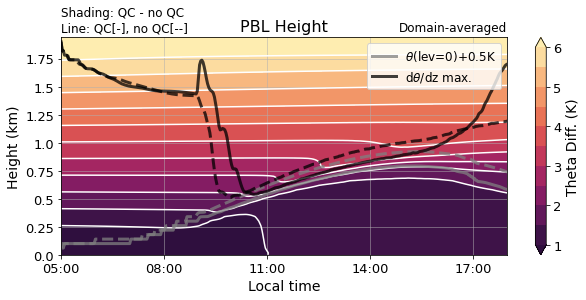

In [274]:
Plot_pbl_diff_theta(savefig=True)